In [1]:
import os
import yaml
from scipy.special import expit
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from regionmask import mask_geopandas
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo

plt.rcParams["font.family"] = ["serif", "sans-serif", "monospace"][0]

# settings
k = 1
wd = ["hazGAN2/projects/bayofbengal_era5", "hazGAN2/projects/poweruk_winter"][k]
generated_suffix = ["", "_trunc02", "_trunc04"][0]
std_string = ["gumbel", "standardised"][k]
v1, v2, v3 = [("ws", "tp", "msl"), ("u10_gust", "v10_gust", "r30")][k]

with open(os.path.join(wd, "config.yaml"), "r") as stream:
    config = yaml.safe_load(stream)

regions = ["East Midlands", "West Midlands", "South West England", "South Wales"]
region_of_interest = regions[0]

season = config["sfunc"]
local_crs = config["local_crs"]

ERROR 1: PROJ: proj_create_from_database: Open of /hn01-home/spet5107/micromamba/envs/hazGAN/share/proj failed


In [2]:
print("Using {} domain.".format(config["domain"]))

Using laplace domain.


In [3]:
def set_size(width, fraction=1):
    """ Set aesthetic figure dimensions to avoid scaling in latex.
    https://tobiasraabe.github.io/post/matplotlib-for-publications/

    Parameters
    ----------
    width: float
            Width in pts
    fraction: float
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5 ** 0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    return fig_width_in, fig_height_in

def laplace(uniform, mu=0, b=1):
    """uniform -> Laplace(mu, b) (quantile function)"""
    maxval = np.max(uniform)
    if maxval == 1:
        warn("Values == 1 found, scaling by 1e-6")
        uniform *= 1 - 1e-6
    if maxval > 1:
        raise ValueError(f"Some uniform > 1 ({maxval})")
    
    return np.where(
        uniform <= 0.5, 
        mu + b * np.log(2 * uniform),
        mu - b * np.log(2 - 2 * uniform)
        )


def inv_laplace(x, mu=0, b=1):
    """Laplace(mu, b) -> uniform (CDF function)."""
    return np.where(
        x <= mu,
        0.5 * np.exp((x - mu) / b),
        1 - 0.5 * np.exp(-(x - mu) / b)
    )


def gumbel(uniform):
    """uniform -> Gumbel(0, 1)"""
    maxval = np.max(uniform)
    if maxval == 1:
        warn("Values == 1 found, scaling by 1e-6")
        uniform *= 1 - 1e-6
    if maxval > 1:
        raise ValueError(f"Some uniform > 1 ({maxval})")
    return -np.log(-np.log(uniform))

In [4]:
print(laplace(0.999) - laplace(0.99))
print(gumbel(0.999) - gumbel(0.99))
print("\nSo laplace stretches the tails very slightly less.")

2.3025850929940455
2.307105843747136

So laplace stretches the tails very slightly less.


| Training max | Generated max |
| --- | --- |
| 5.370638028127642 | 5.39573504192333 |
| 0.9976744186046511 | 0.997732057446276|
| 45.566527478103296 | 45.566527478103296 |

In [5]:
train = xr.open_dataset(os.path.join(wd, "results", "training", "data.nc"))
train["standardised"] = (["time", "lat", "lon", "field"], laplace(train["uniform"]).data)
print(train.sizes)

gener = xr.open_dataset(os.path.join(wd, "results", f"generated{generated_suffix}", "netcdf", "data.nc"), engine="netcdf4")
gener.load() # do the expensive server load once
print(gener.sizes)

Frozen({'time': 429, 'lat': 64, 'lon': 64, 'field': 3, 'month': 3, 'param': 6})
Frozen({'time': 14300, 'lat': 64, 'lon': 64, 'field': 3, 'param': 6})


u10_gust train max: 45.566527478103296, generated max: 45.566527478103296, avg. diff: -0.06282047779780608, max. diff: 0.0
v10_gust train max: 37.11198128724386, generated max: 37.11198128724386, avg. diff: -0.1029682844606615, max. diff: 0.0
r30 train max: 0.07501778227742761, generated max: 0.07518010901929638, avg. diff: -0.003682737501556628, max. diff: 0.0


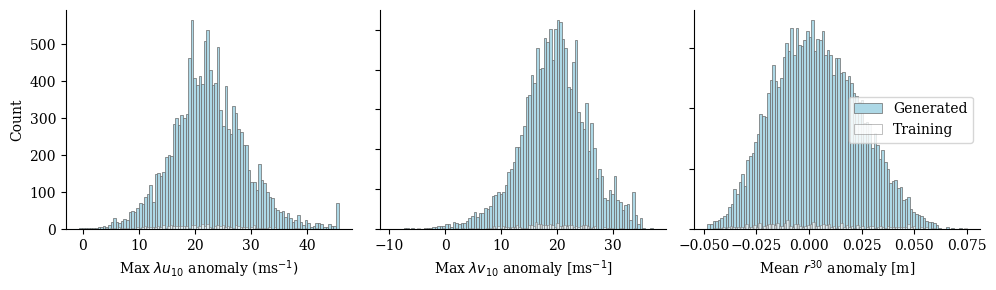

In [6]:
hist_kws = {"edgecolor": 'dimgrey', "linewidth": 0.5, "bins": 100, "density": False}

fig, axs = plt.subplots(1, 3, figsize=(10, 3))

i = 2

domain_train = ["standardised", "uniform", "anomaly"][i] # check the other one
domain_gener = [std_string, "uniform", "anomaly"][i]

q = 0.0

ax = axs[0]
y0 = train.sel(field=v1)[domain_train].max(dim=["lat", "lon"]).values.ravel()
y1 = gener.sel(field=v1)[domain_gener].max(dim=["lat", "lon"]).values.ravel()
dy = (gener.sel(field=v1)[domain_gener].max(dim=["time"]) - train.sel(field=v1)[domain_train].max(dim=["time"])).mean().item()
dy_max = (gener.sel(field=v1)[domain_gener].max(dim=["time"]) - train.sel(field=v1)[domain_train].max(dim=["time"])).max().item()
threshold = np.quantile(y0, q)
y0_tail = y0[y0 > threshold]
y1_tail = y1[y1 > threshold]
ax.hist(y1_tail, color="lightblue", label="Generated", **hist_kws);
ax.hist(y0_tail, color="white", alpha=0.6, label="Training", **hist_kws);
ax.set_xlabel(r"Max $\lambda u_{10}$ anomaly (ms$^{-1})$")
print("{} train max: {}, generated max: {}, avg. diff: {}, max. diff: {}".format(v1, y0.max(), y1.max(), dy, dy_max))

ax = axs[1]
y0 = train.sel(field=v2)[domain_train].max(dim=["lat", "lon"]).values.ravel()
y1 = gener.sel(field=v2)[domain_gener].max(dim=["lat", "lon"]).values.ravel()
dy = (gener.sel(field=v2)[domain_gener].max(dim=["time"]) - train.sel(field=v2)[domain_train].max(dim=["time"])).mean().item()
dy_max = (gener.sel(field=v2)[domain_gener].max(dim=["time"]) - train.sel(field=v2)[domain_train].max(dim=["time"])).max().item()
threshold = np.quantile(y0, q)
y0_tail = y0[y0 > threshold]
y1_tail = y1[y1 > threshold]
ax.hist(y1_tail, color="lightblue", label="Generated", **hist_kws);
ax.hist(y0_tail, color="white", alpha=0.6, label="Training", **hist_kws);
ax.set_xlabel(r"Max $\lambda v_{10}$ anomaly [ms$^{-1}$]")
print("{} train max: {}, generated max: {}, avg. diff: {}, max. diff: {}".format(v2, y0.max(), y1.max(), dy, dy_max))

ax = axs[2]
y0 = train.sel(field=v3)[domain_train].mean(dim=["lat", "lon"]).values.ravel()
y1 = gener.sel(field=v3)[domain_gener].mean(dim=["lat", "lon"]).values.ravel()
dy = (gener.sel(field=v3)[domain_gener].max(dim=["time"]) - train.sel(field=v3)[domain_train].max(dim=["time"])).mean().item()
dy_max = (gener.sel(field=v3)[domain_gener].max(dim=["time"]) - train.sel(field=v3)[domain_train].max(dim=["time"])).max().item()
threshold = np.quantile(y0, q)
y0_tail = y0[y0 > threshold]
y1_tail = y1[y1 > threshold]
ax.hist(y1_tail, color="lightblue", label="Generated", **hist_kws);
ax.hist(y0_tail, color="white", alpha=0.6, label="Training", **hist_kws);
ax.set_xlabel(r"Mean $r^{30}$ anomaly [m]")
ax.legend(loc="center right")
print("{} train max: {}, generated max: {}, avg. diff: {}, max. diff: {}".format(v3, y0.max(), y1.max(), dy, dy_max))

for ax in axs:
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_ylabel("Count")
    ax.label_outer()

plt.tight_layout()

fig.savefig(os.path.join(
    wd, "results", "figures", "tail_hists.png"), dpi=300, transparent=True, bbox_inches="tight")

In [7]:
def format_p(p):
    if isinstance(p, list):
        return {"lon": p[0], "lat": p[1]}
    else:
        return p


u10_gust train max: 24.160895338055106, generated max: 24.160895338055106, diff:  0.0
v10_gust train max: 26.6004402102609, generated max: 26.6004402102609, diff:  0.0
r30 train max: 0.12995624542236328, generated max: 0.12995624542236328, diff:  0.0


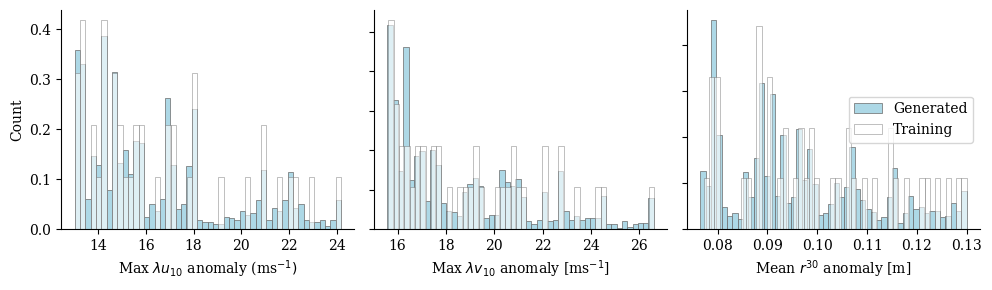

In [8]:
# temp, view train only

p = [format_p(p) for p in config["points_of_interest"].values()][1]
hist_kws = {"edgecolor": 'dimgrey', "linewidth": 0.5, "bins": 50, "density": True}

fig, axs = plt.subplots(1, 3, figsize=(10, 3))

i = 2

domain_train = ["standardised", "uniform", "anomaly"][i] # check the other one
domain_gener = [std_string, "uniform", "anomaly"][i]

q = 0.9

ax = axs[0]
y0 = train.sel(field=v1)[domain_train].sel(**p, method="nearest").values.ravel()
y1 = gener.sel(field=v1)[domain_gener].sel(**p, method="nearest").values.ravel()
threshold = np.quantile(y0, q)
y0_tail = y0[y0 > threshold]
y1_tail = y1[y1 > threshold]
ax.hist(y1_tail, color="lightblue", label="Generated", **hist_kws);
ax.hist(y0_tail, color="white", alpha=0.6, label="Training", **hist_kws);
ax.set_xlabel(r"Max $\lambda u_{10}$ anomaly (ms$^{-1})$")
print("{} train max: {}, generated max: {}, diff: ".format(v1, y0.max(), y1.max()), y1.max() - y0.max())

ax = axs[1]
y0 = train.sel(field=v2)[domain_train].sel(**p, method="nearest").values.ravel()
y1 = gener.sel(field=v2)[domain_gener].sel(**p, method="nearest").values.ravel()
threshold = np.quantile(y0, q)
y0_tail = y0[y0 > threshold]
y1_tail = y1[y1 > threshold]
ax.hist(y1_tail, color="lightblue", label="Generated", **hist_kws);
ax.hist(y0_tail, color="white", alpha=0.6, label="Training", **hist_kws);
ax.set_xlabel(r"Max $\lambda v_{10}$ anomaly [ms$^{-1}$]")
print("{} train max: {}, generated max: {}, diff: ".format(v2, y0.max(), y1.max()), y1.max() - y0.max())

ax = axs[2]
y0 = train.sel(field=v3)[domain_train].sel(**p, method="nearest").values.ravel()
y1 = gener.sel(field=v3)[domain_gener].sel(**p, method="nearest").values.ravel()
threshold = np.quantile(y0, q)
y0_tail = y0[y0 > threshold]
y1_tail = y1[y1 > threshold]
ax.hist(y1_tail, color="lightblue", label="Generated", **hist_kws);
ax.hist(y0_tail, color="white", alpha=0.6, label="Training", **hist_kws);
ax.set_xlabel(r"Mean $r^{30}$ anomaly [m]")
ax.legend(loc="center right")
print("{} train max: {}, generated max: {}, diff: ".format(v3, y0.max(), y1.max()), y1.max() - y0.max())

for ax in axs:
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_ylabel("Count")
    ax.label_outer()

plt.tight_layout()
# fig.suptitle(f"Thresholding tail above {q*100:.0f}th quantile ({domain_train})")

fig.savefig(os.path.join(
    wd, "results", "figures", "tail_hist_marginal.png"), dpi=300, transparent=True, bbox_inches="tight")

Saved as hazGAN2/projects/poweruk_winter/results/figures/scatter_1.png


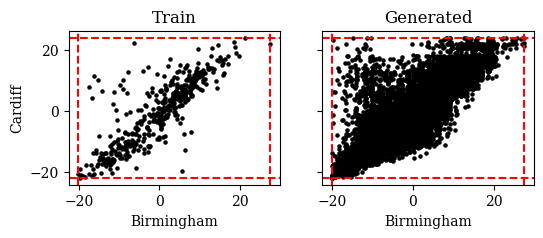

In [9]:
# temp, view train only
p0, p1 = [format_p(p) for p in config["points_of_interest"].values()][:2]
n0, n1 = [name for name in config["points_of_interest"].keys()][:2]

hist_kws = {"edgecolor": 'dimgrey', "linewidth": 0.5, "bins": 50, "density": True}

fig, axs = plt.subplots(1, 2, figsize=(6, 2))

j = 0
domain_train = ["standardised", "uniform", "anomaly"][i] # check the other one
domain_gener = [std_string, "uniform", "anomaly"][i]

ax = axs[0]
y0 = train.sel(field=v1)[domain_train].sel(**p0, method="nearest").values.ravel()
y1 = train.sel(field=v1)[domain_train].sel(**p1, method="nearest").values.ravel()
ax.scatter(y0, y1, color='k', s=5)
y0_min, y0_max = y0.min(), y0.max()
y1_min, y1_max = y1.min(), y1.max()
ax.set_title("Train")

ax = axs[1]
y0 = gener.sel(field=v1)[domain_gener].sel(**p0, method="nearest").values.ravel()
y1 = gener.sel(field=v1)[domain_gener].sel(**p1, method="nearest").values.ravel()
ax.scatter(y0, y1, color='k', s=5)
ax.set_title("Generated")

for ax in axs:
    ax.axhline(y1_min, color="red", linestyle="dashed")
    ax.axhline(y1_max, color="red", linestyle="dashed")
    ax.axvline(y0_min, color="red", linestyle="dashed")
    ax.axvline(y0_max, color="red", linestyle="dashed")
    ax.set_xlabel(n0.title())
    ax.set_ylabel(n1.title())
    ax.label_outer();

outpath = os.path.join(wd, "results", "figures", f"scatter_{k}{generated_suffix}.png")
fig.savefig(outpath, dpi=300, transparent=True, bbox_inches="tight")

print("Saved as {}".format(outpath))